## Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
train = pd.read_csv('../cleaneddata/cleanedTraining.csv', index_col=0)

In [22]:
train.dtypes

0                       float64
1                       float64
2                       float64
3                       float64
4                       float64
5                       float64
6                       float64
7                       float64
8                       float64
9                       float64
10                      float64
11                      float64
12                      float64
13                      float64
14                      float64
LogSales                float64
DayOfWeek                 int64
Store                     int64
WeekNumber                int64
Observed                float64
Trend                   float64
MeanCustomerObserved    float64
dtype: object

In [16]:
#train.isnull().sum()

## Train/Test Split

In [41]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train.drop(['LogSales'], axis=1), 
                                                    train['LogSales'], 
                                                    test_size=0.25, 
                                                    random_state=123)

In [42]:
from sklearn.tree import DecisionTreeRegressor

explore_tree = DecisionTreeRegressor().fit(X_train, y_train)
pred = explore_tree.predict(X_test)

In [43]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(pred, y_test))

print(rmse)

0.179174826577


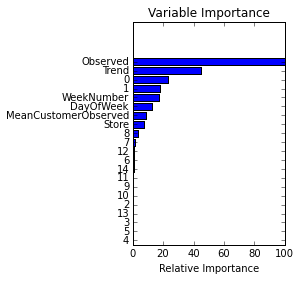

In [44]:
%matplotlib inline
feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [53]:
import xgboost as xgb

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [54]:
val_size = 15000


params = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 12,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 2000
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)
#dtest = xgb.DMatrix(test)
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
gbm5 = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50, feval=rmspe_xg, verbose_eval=True)


Will train until eval error hasn't decreased in 50 rounds.
[0]	train-rmspe:0.998726	eval-rmspe:0.998725
[1]	train-rmspe:0.994787	eval-rmspe:0.994782
[2]	train-rmspe:0.984909	eval-rmspe:0.984896
[3]	train-rmspe:0.964969	eval-rmspe:0.964928
[4]	train-rmspe:0.931526	eval-rmspe:0.931410
[5]	train-rmspe:0.883090	eval-rmspe:0.882799
[6]	train-rmspe:0.820820	eval-rmspe:0.820125
[7]	train-rmspe:0.748318	eval-rmspe:0.746857
[8]	train-rmspe:0.670257	eval-rmspe:0.667465
[9]	train-rmspe:0.591744	eval-rmspe:0.586912
[10]	train-rmspe:0.516845	eval-rmspe:0.509281
[11]	train-rmspe:0.449321	eval-rmspe:0.437769
[12]	train-rmspe:0.390719	eval-rmspe:0.374337
[13]	train-rmspe:0.341856	eval-rmspe:0.320164
[14]	train-rmspe:0.303999	eval-rmspe:0.275561
[15]	train-rmspe:0.271742	eval-rmspe:0.239989
[16]	train-rmspe:0.251194	eval-rmspe:0.213086
[17]	train-rmspe:0.237230	eval-rmspe:0.193139
[18]	train-rmspe:0.227519	eval-rmspe:0.178833
[19]	train-rmspe:0.221911	eval-rmspe:0.169174
[20]	train-rmspe:0.213415	eval-

## Fit a Random Forest

In [46]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor().fit(X_train, y_train)

In [47]:
predictions = rf.predict(X_test)

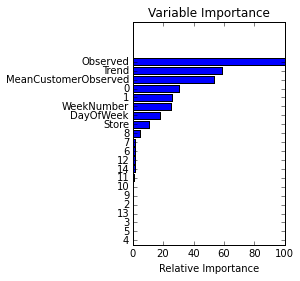

In [48]:
%matplotlib inline
feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [49]:
from sklearn.metrics import mean_squared_error

mean_squared_error(predictions, y_test)

0.023487981624745993

## Cross Validation Time

In [50]:
from sklearn.cross_validation import cross_val_score, cross_val_predict

cv_pred = cross_val_predict(rf, X_train, y_train, cv=5, n_jobs=-1)

In [51]:
mean_squared_error(cv_pred, y_train)

0.023673221161816613

In [52]:
#cv_scores = cross_val_score(rf, X_train, y_train, cv=5)

In [18]:
cv_scores

array([ 0.82619497,  0.82981324,  0.83280576,  0.83177829,  0.82525807])

## Got Another Shit Result, Trying AdaBoost

## Bring in the Evaluation Set

In [56]:
test = pd.read_csv('../cleaneddata/cleanedtest.csv', index_col=0)
test.head()
# test.describe()

,0,1,2,3,4,5,6,7,8,9,...,13,14,DayOfWeek,Store,WeekNumber,Open,Id,Observed,Trend,MeanCustomerObserved
0,0,1,1,0,0,0,1,0,0,0,...,0,0,4,1,38,1,1,8.446489,8.446712,8.446489
1,0,1,1,0,0,0,1,0,0,0,...,0,0,3,1,38,1,857,8.446489,8.446712,8.446489
2,0,1,1,0,0,0,1,0,0,0,...,0,0,2,1,38,1,1713,8.446489,8.446712,8.446489
3,0,1,1,0,0,0,1,0,0,0,...,0,0,1,1,38,1,2569,8.446489,8.446712,8.446489
4,1,0,1,0,0,0,1,0,0,0,...,0,0,7,1,37,0,3425,8.446489,8.446712,8.446489


val_size = 15000


params = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 12,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 2000
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)
dtest = xgb.DMatrix(test)
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
gbm5 = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)


In [57]:
#dtest = xgb.DMatrix(test)

In [58]:
dtest = xgb.DMatrix(test.drop(['Open','Id'], axis=1))

In [59]:
pred_log_sales = gbm5.predict(dtest)

In [61]:
test['Sales'] = np.exp(pred_log_sales)

In [62]:
test.ix[test['Open'] == 0, 'Sales'] = 0

In [63]:
test.ix[:, ['Id', 'Sales']].to_csv('xgboostv6.csv', index=False, header=['Id', 'Sales'])

In [66]:
test.describe()

,0,1,2,3,4,5,6,7,8,9,...,14,DayOfWeek,Store,WeekNumber,Open,Id,Observed,Trend,MeanCustomerObserved,Sales
count,41088.000000,41088.000000,41088.000000,41088.000000,41088,41088,41088.000000,41088.000000,41088.000000,41088.000000,...,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000
mean,0.604167,0.395833,0.995619,0.004381,0,0,0.556513,0.443487,0.538551,0.014019,...,0.495327,3.979167,555.899533,34.645833,0.854361,20544.500000,8.748158,8.748200,8.748158,5635.969238
std,0.489035,0.489035,0.066044,0.066044,0,0,0.496802,0.496802,0.498518,0.117569,...,0.499984,2.015481,320.274496,2.015481,0.352748,11861.228267,0.305093,0.303913,0.305093,3379.678683
min,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,31.000000,0.000000,1.000000,7.841170,7.845857,7.841170,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,279.750000,33.000000,1.000000,10272.750000,8.537835,8.538439,8.537835,4013.349243
50%,1.000000,0.000000,1.000000,0.000000,0,0,1.000000,0.000000,1.000000,0.000000,...,0.000000,4.000000,553.500000,35.000000,1.000000,20544.500000,8.743363,8.742518,8.743363,5662.744873
75%,1.000000,1.000000,1.000000,0.000000,0,0,1.000000,1.000000,1.000000,0.000000,...,1.000000,6.000000,832.250000,36.000000,1.000000,30816.250000,8.930526,8.929623,8.930526,7455.414673
max,1.000000,1.000000,1.000000,1.000000,0,0,1.000000,1.000000,1.000000,1.000000,...,1.000000,7.000000,1115.000000,38.000000,1.000000,41088.000000,9.922477,9.918074,9.922477,32679.511719
